## Latch Task

This experimental notebook concerns the _latch_ task where we ask a neural net to produce zeros until a 1 occurs in the input, after which it should produce only ones until the next 1 occurs in the input, switching it back to zero, and so on.

In [2]:
import random
import numpy as np

# define the input generating function
def generate_seq(max_len, num_switches):
    # start by sampling the sequence length
    T = random.randrange(num_switches * 3, max_len)
    # initialize the input and output sequence
    X = np.zeros((T, 1))
    Y = np.zeros((T, 1))
    # sample the switching points
    t_last = 0
    for j in range(num_switches):
        lo = int(T / num_switches) * j + int(0.25 * T / num_switches)
        hi = int(T / num_switches) * (j+1) - int(0.25 * T / num_switches)
        t  = random.randrange(lo, hi)
        X[t, :] = 1.
        Y[t_last:t, :] = j % 2
        t_last = t
    Y[t_last:, :] = num_switches % 2
    return X, Y

# generate the input data
num_folds = 20
num_seqs_per_fold = 20
max_len = 200
num_switches = 3
Data = []
for f in range(num_folds):
    Xs = []
    Ys = []
    for j in range(num_seqs_per_fold):
        X, Y = generate_seq(max_len, num_switches)
        Xs.append(X)
        Ys.append(Y)
    Data.append((Xs, Ys))

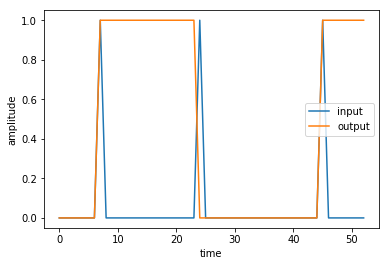

In [5]:
import matplotlib.pyplot as plt
# plot an example data sequence
X, Y = generate_seq(200, 3)
plt.plot(X)
plt.plot(Y)
plt.xlabel('time')
plt.ylabel('amplitude')
plt.legend(['input', 'output'])
plt.show()

In [4]:
# set the hyper-parameter ranges for all models
models = ['ESN', 'ESGRU', 'RMM']
ms   = [64]

vs   = [0.8, 0.9, 0.99]
w_cs = [0.2, 0.4]
w_js = [0.6, 0.8]
ls   = [4, 8]
leaks = [0.5, 0.7]


v_gates = [0.2, 0.4, 0.8, 1.6]
bases = [4, 8, 16]
steps_selfs  = [1, 2, 4]
steps_others = [1, 2, 4]
Ks   = [2]
bias_writes = [0.1, 0.2, 0.4]
bias_reads  = [0.1, 0.2, 0.4]
num_reads  = [4, 8, 16]
policy_initializations  = ['identity']
reguls = [1E-5]
input_normalizations = [False]
washouts = [0]
perm_dubs = [False]

R = 10
num_hyperopt_folds = 3

In [6]:
# perform a crossvalidation and compare the results
# of all models
import rmm.hyperopt as hyperopt

errs   = np.zeros((len(models), num_folds))

for f in range(num_folds):
    print('--- fold %d of %d ---' % (f+1, num_folds))
    # accumulate the training data
    Xs = []
    Ys = []
    for f2 in range(num_folds):
        if f == f2:
            continue
        Xs += Data[f2][0]
        Ys += Data[f2][1]
    Xs_test = Data[f][0]
    Ys_test = Data[f][1]
    # iterate over the models
    for m in range(len(models)):
        print('starting hyper-parameter optimization for %s' % models[m])
        # train the model with hyperparameter optimization on a subset
        # of folds
        perm = np.random.permutation(num_folds)
        perm = perm[perm != f]
        train_folds = []
        for f3 in perm[:num_hyperopt_folds]:
            train_folds.append(Data[f3])
        if models[m] == 'ESN':
            model, _, _, _ = hyperopt.hyperopt_esn(train_folds, R, ms, vs, w_cs, w_js, ls, leaks, reguls, input_normalizations, washouts)
        elif models[m] == 'ESGRU':
            model, _, _, _ = hyperopt.hyperopt_esgru(train_folds, R, ms, vs, w_cs, w_js, ls, v_gates, reguls, input_normalizations, washouts)
        elif models[m] == 'RMM':
            model, _, _, _ = hyperopt.hyperopt_rmm(train_folds, R, ms, vs, w_cs, w_js, ls, leaks, Ks, policy_initializations, perm_dubs, reguls, input_normalizations, washouts)
        else:
            raise ValueError('Unsupported Model type: %s' % models[m])
        # train the model
        print('fitting %s' % models[m])
        model.fit(Xs, Ys)
        # evaluate the model on the test data
        for j in range(len(Xs_test)):
            Yhat = model.predict(Xs_test[j])
            errs[m, f] += np.sqrt(np.mean(np.square(Ys_test[j] - Yhat)))
        errs[m, f] /= len(Xs_test)
        print('completed %s' % models[m])

/usr/lib64/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


--- fold 1 of 20 ---
starting hyper-parameter optimization for ESN
fitting ESN
completed ESN
starting hyper-parameter optimization for ESGRU
fitting ESGRU
completed ESGRU
starting hyper-parameter optimization for RMM
fitting RMM
completed RMM
--- fold 2 of 20 ---
starting hyper-parameter optimization for ESN
fitting ESN
completed ESN
starting hyper-parameter optimization for ESGRU
fitting ESGRU
completed ESGRU
starting hyper-parameter optimization for RMM
fitting RMM
completed RMM
--- fold 3 of 20 ---
starting hyper-parameter optimization for ESN
fitting ESN
completed ESN
starting hyper-parameter optimization for ESGRU
fitting ESGRU
completed ESGRU
starting hyper-parameter optimization for RMM
fitting RMM
completed RMM
--- fold 4 of 20 ---
starting hyper-parameter optimization for ESN
fitting ESN
completed ESN
starting hyper-parameter optimization for ESGRU
fitting ESGRU
completed ESGRU
starting hyper-parameter optimization for RMM
fitting RMM
completed RMM
--- fold 5 of 20 ---
startin

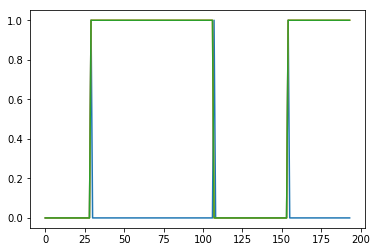

In [7]:
import matplotlib.pyplot as plt
plt.plot(Xs_test[j])
plt.plot(Ys_test[j])
plt.plot(Yhat)
plt.show()

In [8]:
for m in range(len(models)):
    print('RMSE for %s: %g +- %g' % (models[m], np.mean(errs[m, :]), np.std(errs[m, :])))

RMSE for ESN: 0.315586 +- 0.0726845
RMSE for ESGRU: 0.359427 +- 0.0488978
RMSE for RMM: 0.00156017 +- 0.00596555


error for long sequence is 0.000000


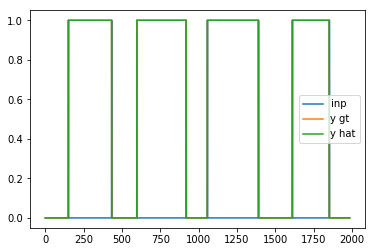

In [9]:
# challenge the model with even longer sequences
X, Y = generate_seq(2000, num_switches+5)
Yhat = model.predict(X)
err_long = np.sqrt(np.mean(np.square(Y - Yhat)))
print('error for long sequence is %f' %err_long)

plt.plot(X)
plt.plot(Y)
plt.plot(Yhat)
plt.legend(['inp', 'y gt', 'y hat'])
plt.show()
